In [1]:
import torch
import pandas as pd

#from transformers import BertTokenizer, BertForSequenceClassification, LongformerTokenizer, LongformerForSequenceClassification
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.autograd.profiler as profiler


In [2]:
df = pd.read_csv('/data/home/yjkim/DACON/Cancer/create_token.csv')
train = pd.read_csv("/data/home/yjkim/DACON/Cancer/train.csv")
test = pd.read_csv("/data/home/yjkim/DACON/Cancer/test.csv")

In [3]:
df

,Unnamed: 0,Sample,Gene,Mutation,Mutation Type,Extracted Number 1,Extracted Number 2
0,0,0,ABCC2,D623D,silent,623,NaN
1,1,0,ADCY2,F736C,missense,736,NaN
2,2,0,CD86,P117R,missense,117,NaN
3,3,0,EPHB4,R305S,missense,305,NaN
4,4,0,FOXC2,N23K,missense,23,NaN
...,...,...,...,...,...,...,...
249059,503134,6200,TRIO,E1958K,missense,1958,NaN
249060,503135,6200,TULP2,E141K,missense,141,NaN
249061,503144,6200,WASF1,L137F,missense,137,NaN
249062,503147,6200,WFS1,V498I,missense,498,NaN


In [4]:
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [3]:
def create_token(row):
    # If there's a second extracted number, include it
    if pd.notna(row['Extracted Number 2']):
        return f"{row['Gene']}-{row['Mutation Type']}-{row['Extracted Number 1']}-{row['Extracted Number 2']}"
    else:
        return f"{row['Gene']}-{row['Mutation Type']}-{row['Extracted Number 1']}"

In [4]:
df['Token'] = df.apply(create_token, axis=1)
df_grouped = df.groupby('Sample')['Token'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped.columns = ['Sample', 'Token_Sequence']

In [7]:
df_grouped

,Sample,Token_Sequence
0,0,ABCC2-silent-623 ADCY2-missense-736 CD86-misse...
1,1,ABCC8-missense-1115 ATRX-frame_shift-1854 DTX1...
2,2,A2M-silent-895 ABCB11-silent-426 ABCC8-missens...
3,3,EGFR-missense-838 EIF4G2-nonsense-197 F5-silen...
4,4,AHNAK-missense-1479 ALOX15B-silent-145 C8B-mis...
...,...,...
6102,6196,ABCB8-missense-101 ACSL4-missense-590 ACTC1-mi...
6103,6197,ADD2-silent-492 AVPR1A-missense-233 FLT4-misse...
6104,6198,ADAM2-missense-621 ADD2-silent-525 APC-nonsens...
6105,6199,ARHGAP4-silent-853 HIBCH-missense-41 IGSF1-mis...


In [5]:
expected_samples = set(range(6201))  # samples expected from 0 to 6200
actual_samples = set(df_grouped['Sample'])  # the actual sample numbers present in the data

# Identify missing samples
missing_samples = sorted(list(expected_samples - actual_samples))

# Print the missing samples
print(missing_samples)

[66, 102, 122, 129, 133, 256, 412, 413, 576, 636, 671, 781, 813, 825, 894, 1007, 1121, 1386, 1425, 1460, 1480, 1555, 1587, 1753, 1759, 1786, 1808, 2082, 2284, 2295, 2317, 2426, 2515, 2531, 2545, 2613, 2628, 2630, 2639, 2646, 2776, 2778, 2794, 2796, 2823, 3016, 3055, 3093, 3108, 3258, 3324, 3469, 3476, 3583, 3597, 3663, 3668, 3789, 3904, 3960, 4004, 4044, 4122, 4310, 4389, 4421, 4467, 4572, 4655, 4686, 4788, 4823, 4879, 4904, 4941, 5084, 5114, 5138, 5193, 5207, 5291, 5297, 5345, 5354, 5529, 5625, 5648, 5708, 5749, 5798, 5804, 5972, 6116, 6134]


In [6]:
missing_data = pd.DataFrame({
    'Sample': missing_samples,
    'Token_Sequence': 'all WT'
})
df_combined = pd.concat([df_grouped, missing_data], ignore_index=True).sort_values(by='Sample').reset_index(drop=True)

In [10]:
df_combined

,Sample,Token_Sequence
0,0,ABCC2-silent-623 ADCY2-missense-736 CD86-misse...
1,1,ABCC8-missense-1115 ATRX-frame_shift-1854 DTX1...
2,2,A2M-silent-895 ABCB11-silent-426 ABCC8-missens...
3,3,EGFR-missense-838 EIF4G2-nonsense-197 F5-silen...
4,4,AHNAK-missense-1479 ALOX15B-silent-145 C8B-mis...
...,...,...
6196,6196,ABCB8-missense-101 ACSL4-missense-590 ACTC1-mi...
6197,6197,ADD2-silent-492 AVPR1A-missense-233 FLT4-misse...
6198,6198,ADAM2-missense-621 ADD2-silent-525 APC-nonsens...
6199,6199,ARHGAP4-silent-853 HIBCH-missense-41 IGSF1-mis...


In [11]:
df_combined.iloc[1789,:]

Sample                                                         1789
Token_Sequence    A2M-silent-1255 A2M-silent-814 A2M-missense-55...
Name: 1789, dtype: object

[(66, 'KIPAN'), (102, 'THYM'), (122, 'THCA'), (129, 'LUSC'), (133, 'SARC'), (256, 'LAML'), (412, 'THYM'), (413, 'THYM'), (576, 'THYM'), (636, 'THYM'), (671, 'LGG'), (781, 'CESC'), (813, 'LAML'), (825, 'BRCA'), (894, 'THYM'), (1007, 'LAML'), (1121, 'THCA'), (1386, 'THCA'), (1425, 'THYM'), (1460, 'THYM'), (1480, 'THYM'), (1555, 'THCA'), (1587, 'THYM'), (1753, 'LAML'), (1759, 'LAML'), (1786, 'THCA'), (1808, 'BRCA'), (2082, 'THYM'), (2284, 'BRCA'), (2295, 'PRAD'), (2317, 'LAML'), (2426, 'KIPAN'), (2515, 'THYM'), (2531, 'CESC'), (2545, 'THYM'), (2613, 'PRAD'), (2628, 'THYM'), (2630, 'THCA'), (2639, 'STES'), (2646, 'THCA'), (2776, 'THYM'), (2778, 'THCA'), (2794, 'THYM'), (2796, 'BRCA'), (2823, 'LUSC'), (3016, 'THCA'), (3055, 'THCA'), (3093, 'GBMLGG'), (3108, 'LAML'), (3258, 'THYM'), (3324, 'PCPG'), (3469, 'THYM'), (3476, 'THCA'), (3583, 'KIRC'), (3597, 'THYM'), (3663, 'THYM'), (3668, 'THCA'), (3789, 'THYM'), (3904, 'THYM'), (3960, 'THYM'), (4004, 'KIRC'), (4044, 'PRAD'), (4122, 'THYM'), (431

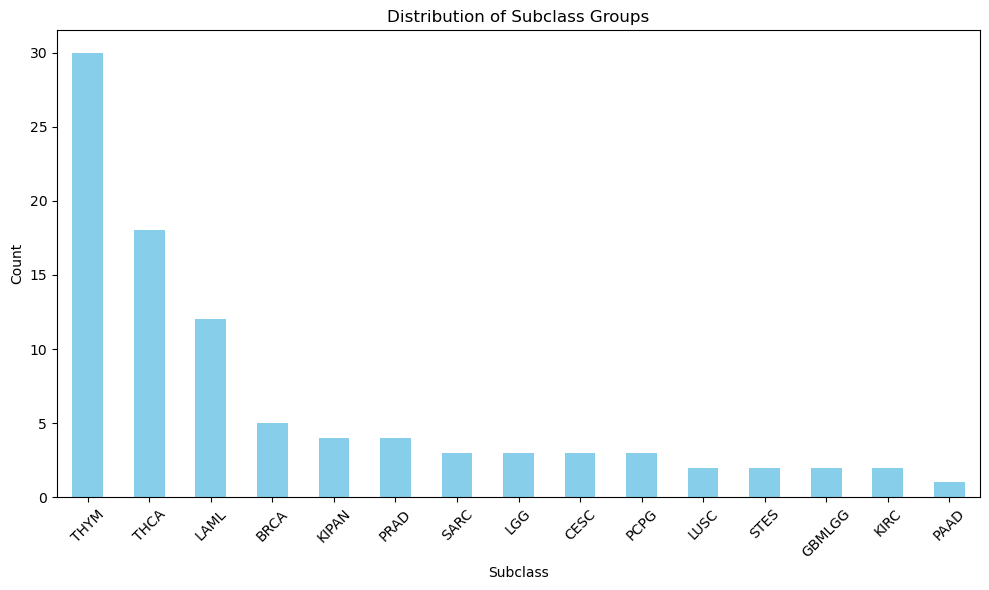

In [7]:
value_list = []
for i in missing_samples:
    value = train.iloc[i]['SUBCLASS']
    value_list.append((i, value))
print(value_list)

df = pd.DataFrame(value_list, columns=['ID', 'Subclass'])
grouped_data = df['Subclass'].value_counts()

plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar', color='skyblue')
plt.title('Distribution of Subclass Groups')
plt.xlabel('Subclass')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

In [13]:
df_combined

,Sample,Token_Sequence
0,0,ABCC2-silent-623 ADCY2-missense-736 CD86-misse...
1,1,ABCC8-missense-1115 ATRX-frame_shift-1854 DTX1...
2,2,A2M-silent-895 ABCB11-silent-426 ABCC8-missens...
3,3,EGFR-missense-838 EIF4G2-nonsense-197 F5-silen...
4,4,AHNAK-missense-1479 ALOX15B-silent-145 C8B-mis...
...,...,...
6196,6196,ABCB8-missense-101 ACSL4-missense-590 ACTC1-mi...
6197,6197,ADD2-silent-492 AVPR1A-missense-233 FLT4-misse...
6198,6198,ADAM2-missense-621 ADD2-silent-525 APC-nonsens...
6199,6199,ARHGAP4-silent-853 HIBCH-missense-41 IGSF1-mis...


In [8]:
le = LabelEncoder()
df_combined['Class_Encoded'] = le.fit_transform(train['SUBCLASS']) 

In [9]:
df_combined

,Sample,Token_Sequence,Class_Encoded
0,0,ABCC2-silent-623 ADCY2-missense-736 CD86-misse...,8
1,1,ABCC8-missense-1115 ATRX-frame_shift-1854 DTX1...,19
2,2,A2M-silent-895 ABCB11-silent-426 ABCC8-missens...,20
3,3,EGFR-missense-838 EIF4G2-nonsense-197 F5-silen...,9
4,4,AHNAK-missense-1479 ALOX15B-silent-145 C8B-mis...,6
...,...,...,...
6196,6196,ABCB8-missense-101 ACSL4-missense-590 ACTC1-mi...,13
6197,6197,ADD2-silent-492 AVPR1A-missense-233 FLT4-misse...,11
6198,6198,ADAM2-missense-621 ADD2-silent-525 APC-nonsens...,4
6199,6199,ARHGAP4-silent-853 HIBCH-missense-41 IGSF1-mis...,22


In [10]:
df_sampled = df_combined.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [11]:
df_sampled

,Sample,Token_Sequence,Class_Encoded
0,5368,CD2-nonsense-248 LBR-missense-504 PIK3CA-misse...,2
1,2463,ABCA1-missense-1401 ABCA2-silent-1827 ABCA8-no...,1
2,2505,APOBEC3G-missense-170 CKAP5-missense-301 CKAP5...,13
3,5418,ATRX-frame_shift-886 CCND3-frame_shift-274 CEP...,6
4,1315,ABHD4-missense-305 FAM120A-silent-804 HUWE1-mi...,19
...,...,...,...
3095,1278,ACE-missense-629 AHNAK-silent-2465 ANKRD2-sile...,7
3096,4370,ABAT-silent-141 ABCA8-missense-751 AHNAK-silen...,2
3097,1621,ABCA3-silent-135 ADIPOR1-silent-107 ARID5B-mis...,5
3098,2561,ANXA2-missense-19 APOH-missense-307 FLNC-silen...,3


In [12]:
import sentencepiece
print(sentencepiece.__version__)

0.2.0


In [13]:
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

In [14]:
from transformers import BigBirdTokenizer

# Load the tokenizer (BigBird in this case)
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

# Example token sequence from your dataset
example_sample = df_combined['Token_Sequence'][1369]  # Taking the first sample, for example

# Tokenize the sample
tokenized_output = tokenizer(
    example_sample,
    padding=False,  # Optional: Pad the sequence
    truncation=False,  # Optional: Truncate if it exceeds max_length
)

# Show the tokenized output
print("Token length:", len(tokenized_output['input_ids']))
print("Tokenized Input IDs:", tokenized_output['input_ids'])
print("Attention Mask:", tokenized_output['attention_mask'])


# Decode the tokenized input back to text (to verify the tokenization process)
decoded_text = tokenizer.decode(tokenized_output['input_ids'][0], skip_special_tokens=True)
print("Decoded Text:", decoded_text)


Token indices sequence length is longer than the specified maximum sequence length for this model (41756 > 4096). Running this sequence through the model will result in indexing errors


Token length: 41756
Tokenized Input IDs: [65, 418, 118, 145, 113, 25514, 33920, 113, 117, 36345, 418, 118, 145, 113, 25514, 33920, 113, 31676, 418, 118, 145, 113, 25514, 33920, 113, 20299, 16024, 2022, 113, 25514, 33920, 113, 23097, 16024, 2022, 113, 18318, 399, 113, 24237, 418, 2986, 1505, 113, 25514, 33920, 113, 25808, 418, 47480, 113, 25514, 33920, 113, 23617, 9665, 8242, 117, 113, 25514, 33920, 113, 6521, 9665, 8242, 118, 113, 25514, 33920, 113, 117, 40357, 9665, 8242, 118, 113, 18318, 399, 113, 117, 29220, 9665, 8242, 118, 113, 18318, 399, 113, 1230, 2881, 9665, 8242, 118, 113, 25514, 33920, 113, 117, 24794, 9665, 8242, 118, 113, 18318, 399, 113, 117, 47622, 9665, 8242, 119, 113, 18318, 399, 113, 33882, 9665, 8242, 119, 113, 25514, 33920, 113, 4862, 9665, 8242, 119, 113, 18318, 399, 113, 26818, 9665, 8242, 119, 113, 18318, 399, 113, 117, 49453, 9665, 8242, 120, 113, 25514, 33920, 113, 125, 2771, 9665, 8242, 120, 113, 18318, 399, 113, 117, 13565, 9665, 8242, 120, 113, 25514, 33920,

In [16]:
decoded_text
element_count = len(decoded_text.split())

# 결과 출력
print(f"요소의 수: {element_count}")

요소의 수: 1


In [41]:
# Tokenize the sequences with Longformer (max length of 4096 tokens)
tokenized_inputs = tokenizer(
    df_sampled['Token_Sequence'].tolist(),
    #df_combined['Token_Sequence'].tolist(),
    padding=True,
    truncation=True,
    max_length=2048,  # 2400 Longformer's max token length
    return_tensors="pt"
)

In [42]:
labels = torch.tensor(df_sampled['Class_Encoded'].values)
#labels = torch.tensor(df_combined['Class_Encoded'].values)

In [43]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    tokenized_inputs['input_ids'], labels, test_size=0.2, random_state=42
)

In [44]:
# Convert the data to DataLoader format
train_dataset = TensorDataset(X_train, tokenized_inputs['attention_mask'][:len(X_train)], y_train)
val_dataset = TensorDataset(X_val, tokenized_inputs['attention_mask'][len(X_train):], y_val)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [45]:
# Load Longformer for sequence classification
num_labels = len(le.classes_)
model =  BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base', num_labels=num_labels)

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [47]:
model.to(device)

BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(50358, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [48]:
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

In [49]:
from torch.cuda.amp import autocast, GradScaler # For mixed precision training
scaler = GradScaler()

In [ ]:
# Training Loop with Profiling
for epoch in range(10):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed precision training for performance
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Validation Loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

val_accuracy = correct / total
print(f"Validation Accuracy: {val_accuracy:.4f}")

Epoch 1, Train Loss: 3.1274, Train Accuracy: 0.1077
Epoch 2, Train Loss: 3.1084, Train Accuracy: 0.1165
Epoch 3, Train Loss: 3.1034, Train Accuracy: 0.1177


In [28]:
# Profiling inside the training loop only (skipping data loading part)
for epoch in range(3):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        # Start profiling from here (excluding data loading)
        with profiler.profile(use_cuda=True, record_shapes=True) as prof:
            with profiler.record_function("forward_pass"):
                with autocast():  # Mixed precision forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            total_train_loss += loss.item()

            # Backward pass with mixed precision
            with profiler.record_function("backward_pass"):
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Print profiling result
print(prof.key_averages().table(sort_by="cuda_time_total"))


STAGE:2024-10-09 16:33:48 2459085:2459085 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
STAGE:2024-10-09 16:33:51 2459085:2459085 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-10-09 16:33:51 2459085:2459085 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-10-09 16:33:53 2459085:2459085 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-10-09 16:33:55 2459085:2459085 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-10-09 16:33:55 2459085:2459085 ActivityProfilerController.cpp:324] Comple

KeyboardInterrupt: 

In [61]:
model.train()
for epoch in range(3):  # Let's say 3 epochs
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Calculate validation accuracy
val_accuracy = correct / total
print(f"Validation Accuracy: {val_accuracy:.4f}")

Initializing global attention on CLS token...


Epoch 1, Loss: 3.353752613067627
Epoch 1, Loss: 3.21519136428833
Epoch 1, Loss: 3.1694297790527344
Epoch 1, Loss: 3.267528772354126
Epoch 1, Loss: 3.3006062507629395
Epoch 1, Loss: 2.9864959716796875
Epoch 1, Loss: 2.886775493621826
Epoch 1, Loss: 3.1934151649475098
Epoch 1, Loss: 3.4229345321655273
Epoch 1, Loss: 2.8910927772521973
Epoch 1, Loss: 3.2821357250213623
Epoch 1, Loss: 3.0738332271575928


KeyboardInterrupt: 